In [1]:
import rasterio as rio
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import dask as da
import h5py as h5
import geopandas as gpd
import pandas as pd
from spectral.io import envi

# enable fiona KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# basemap
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)

point CRS: {'init': 'epsg:32613'}


In [3]:
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*
data_dirs_SWIR, data_dirs_VNIR

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [4]:
## try to open one of the data files with xarray
data_file_VNIR = radiance_files_VNIR_april09[0]
data_file_SWIR = radiance_files_SWIR_april09[0]



In [5]:
def hw_create_xarr_from_envi_file(hwfile, nodata=-9999):

    ## read the array and transform info
    with rio.open(hwfile) as src:
        prof = src.profile
        meta = src.meta
        arr = src.read()
        
    # get the wavelengths from the ENVI header
    envi_meta = envi.open(hwfile + '.hdr').metadata
    wavelength = [float(l) for l in envi_meta['wavelength']]
    
    # get some coordinate array information
    aff = meta['transform']
    pix_size_x = aff.a
    ul_x = aff.c
    pix_size_y = aff.e
    ul_y = aff.f
    
    # move bands to back
    arr = np.rollaxis(arr, 0, 3)
    
    # create the lon / lat coordinate arrays
    x = np.arange(ul_x, ul_x + pix_size_x*arr.shape[1], pix_size_x)
    y = np.arange(ul_y, ul_y + pix_size_y* arr.shape[0], pix_size_y)
    
    # dimension check
    if x.shape[0] != arr.shape[1]:
        # do something
        xsh = x.shape[0]
        ash = arr.shape[1]
        dif = xsh - ash
        
        # xdim more entries than array columns
        if dif > 0:
            x = x[:-dif]
        
        # xdim less entries than array columns
        else:
            raise ValueError('check your affine transform. xdim entries less than array columns')
    
    if y.shape[0] != arr.shape[0]:
        # do something
        ysh = y.shape[0]
        ash = arr.shape[0]
        dif = ysh - ash
        
        # ydim more entries than array rows
        if dif > 0:
            y = y[:-dif]
        
        # ydim less entries than array rows
        else:
            raise ValueError('check your affine transform. xdim entries less than array columns')
    
    print(arr.shape)
    print(x.shape)
    print(y.shape)
    
    # create the xarray and mask out the nodata
    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != nodata)
    
    return x, y, xr_cube_ma
        
        


In [6]:
x_vnir, y_vnir, xarr_VNIR = hw_create_xarr_from_envi_file(data_file_VNIR)
x_swir, y_swir, xarr_SWIR = hw_create_xarr_from_envi_file(data_file_SWIR)

(3194, 872, 270)
(872,)
(3194,)
(3270, 960, 270)
(960,)
(3270,)


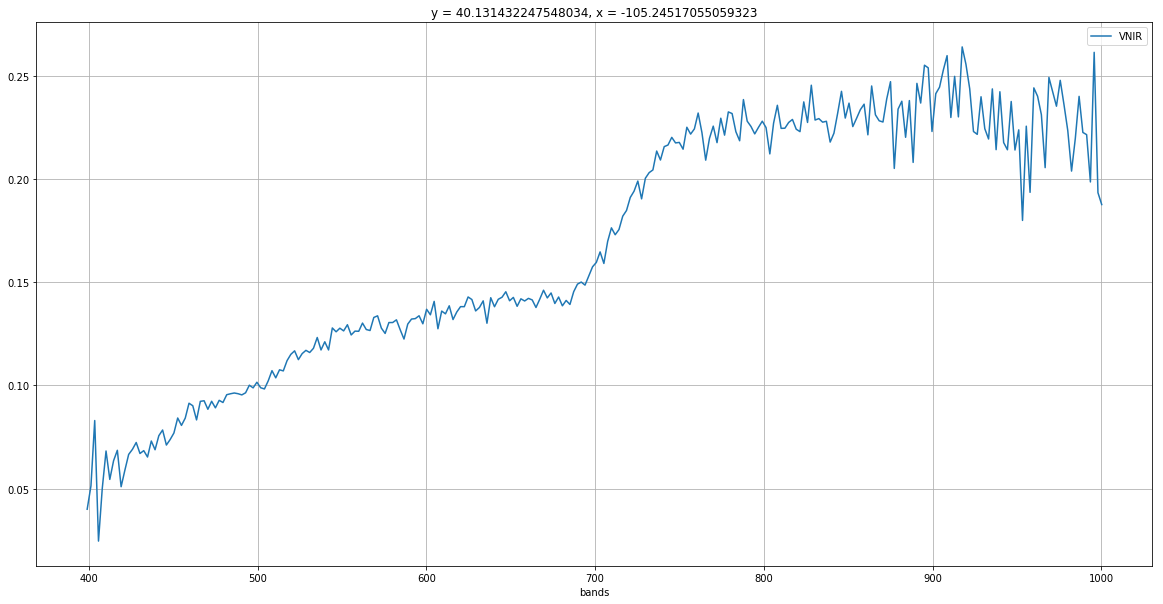

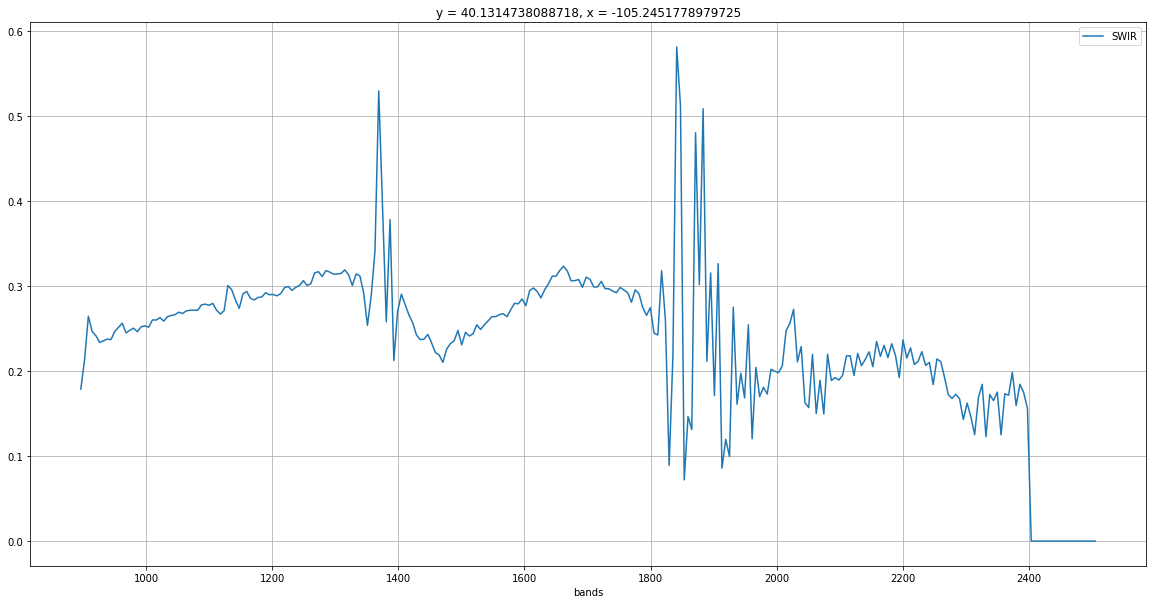

In [7]:
plt.figure(figsize=(20,10))
vnir_sample = xarr_VNIR[200,200,:]
vnir_sample.plot(label='VNIR')
plt.grid(True)
plt.legend()
# plt.title('VNIR plot')
plt.show()

plt.figure(figsize=(20,10))
swir_sample = xarr_SWIR[200,200,:]
swir_sample.plot(label='SWIR')
plt.grid(True)
plt.legend()
# plt.title('SWIR plot')

plt.show()

(540,)


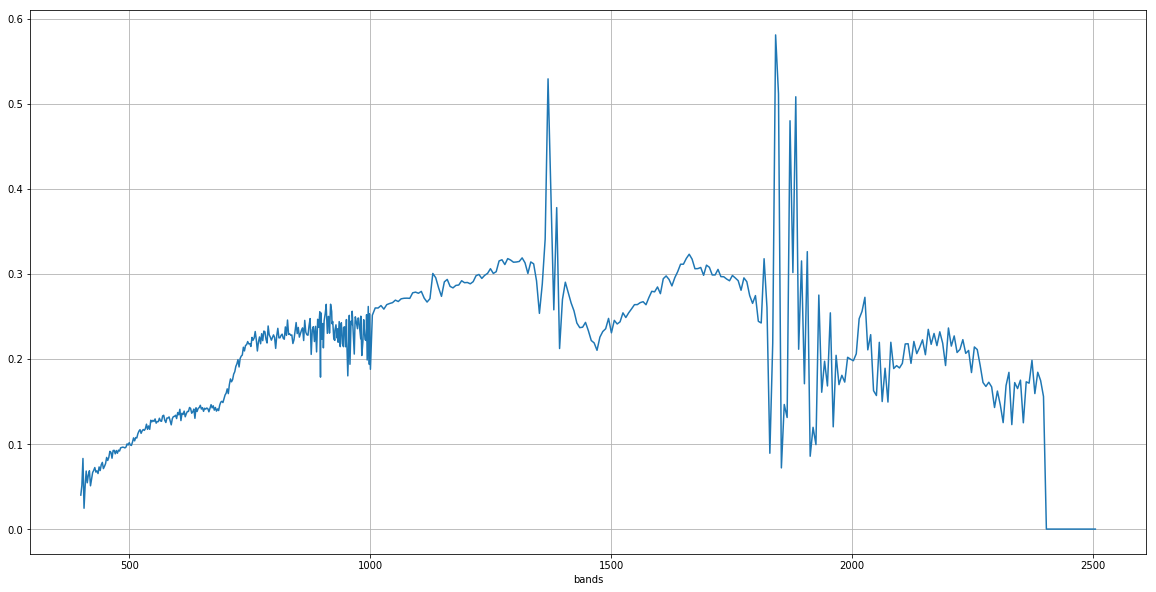

In [8]:
#full_sample = xr.concat([vnir_sample, swir_sample], dim='bands')
# full_sample = xr.merge([vnir_sample, swir_sample])
full_sample = vnir_sample.combine_first(swir_sample)
print(full_sample.shape)


plt.figure(figsize=(20,10))
full_sample.plot()
plt.grid(True)
plt.show()

In [9]:
# combine full headwall cubes? memory error, consider converting to dask array first
xarr_VNIR[200:210, 200:210,:].combine_first(xarr_SWIR[200:210, 200:210,:]).shape # works for subsets

(20, 20, 540)

# Simulate a spatial extraction

In [10]:
from shapely.geometry import Point

# cross-roads point
buffer_dist = 2 # meters
pt = Point(-105.24512887001036, 40.1302875511837)
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))
pt_df = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)

# Create a raster mask with the point geometry


In [11]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [12]:
# create mask datasets for the VNIR and SWIR data separately
ds_vnir = xr.Dataset(coords={'y':y_vnir, 'x':x_vnir})
shapes = [(shape, n) for n, shape in enumerate(pt_df.geometry)]
ds_vnir['aoi'] = rasterize(shapes, ds_vnir.coords)
ds_vnir['aoi'] = ds_vnir.aoi + 1

ds_swir = xr.Dataset(coords={'y':y_swir, 'x':x_swir})
shapes = [(shape, n) for n, shape in enumerate(pt_df.geometry)]
ds_swir['aoi'] = rasterize(shapes, ds_swir.coords)
ds_swir['aoi'] = ds_swir.aoi + 1

In [13]:
# apply the mask to the data cube
example_vnir = ds_vnir.aoi * xarr_VNIR 
example_swir = ds_swir.aoi * xarr_SWIR

In [15]:
# get the valid y and x coordinates, then reduce to unique values
val_y, val_x = np.where(ds_vnir.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_vnir = example_vnir.sel(y=y_vnir[u_y], x=x_vnir[u_x])

val_y, val_x = np.where(ds_swir.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_swir = example_swir.sel(y=y_swir[u_y], x=x_swir[u_x])

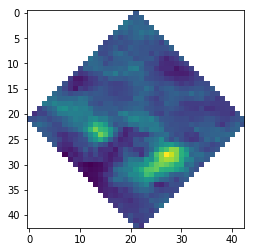

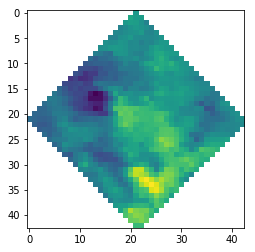

In [16]:
plt.imshow(ex_vnir[:,:,34])
plt.show()

plt.imshow(ex_swir[:,:,34])
plt.show()

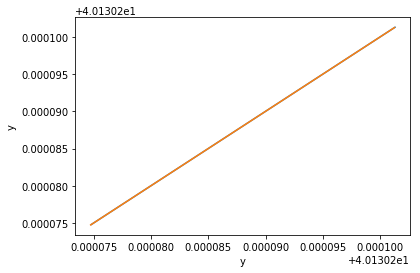

In [41]:
# check the coordinates
plt.figure()
ex_vnir.coords['y'].plot(label='vnir') 
ex_swir.coords['y'].plot(label='swir')
plt.show()

In [49]:
# concatenate the data
print('vnir shape', ex_vnir.shape)
print('swir shape', ex_swir.shape)
# full_ex = ex_vnir.combine_first(ex_swir)
# full_ex = xr.concat(xr.broadcast(ex_vnir, ex_swir), dim='wavelength')
full_ex = np.vstack((ex_vnir.values.reshape(-1, ex_vnir.shape[-1]).T, ex_swir.values.reshape(-1, ex_swir.shape[-1]).T))

print('full_ex shape', full_ex.shape)

vnir shape (43, 43, 270)
swir shape (43, 43, 270)
full_ex shape (540, 1849)


In [ ]:
# concatenate the wavelength vectors
full_wav = np.concatenate((ex_vnir.coords['bands'].values, ex_swir.coords['bands'].values))
full_wav = np.unique(full_wav)

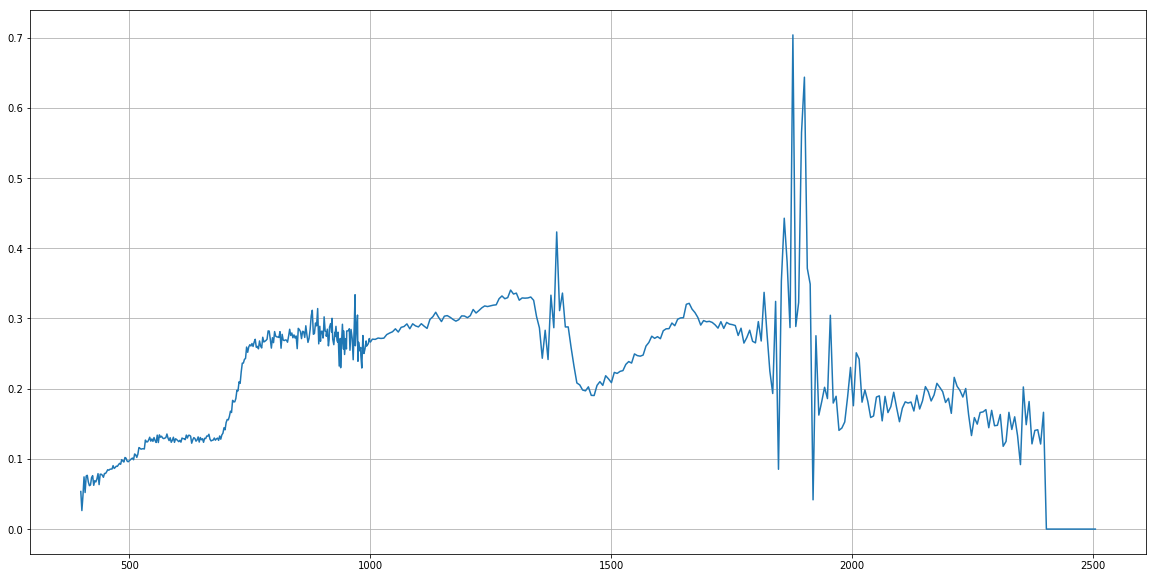

In [70]:
# plot one!
plt.figure(figsize=(20,10))
# plt.plot(full_ex.values.reshape(-1, full_ex.shape[-1]).T) # this plots all of them at unit spacing
plt.plot(full_wav, full_ex[:,400]) # this plots at spacing defined by wavelength vector
plt.grid(True)
plt.show()

# convert the data array to a dask array with the .chunk method